In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# Load the data
data = pd.read_csv('daten.csv', delimiter=';')
data.head()  # Display the first few ro

,date,steps,distance,calories,heart_rate
0,27.04.2016,4948,3242,281,74
1,28.04.2016,16573,12060,751,72
2,29.04.2016,18002,12916,737,75
3,30.04.2016,4126,2981,207,73
4,01.05.2016,3869,2651,244,70


In [25]:
data.head()

,date,steps,distance,calories,heart_rate
0,27.04.2016,4948,3242,281,74
1,28.04.2016,16573,12060,751,72
2,29.04.2016,18002,12916,737,75
3,30.04.2016,4126,2981,207,73
4,01.05.2016,3869,2651,244,70


In [31]:
data.describe()

,steps,distance,calories,heart_rate
count,2454.000000,2454.000000,2454.000000,2454.000000
mean,8262.905460,5955.612469,240.008150,72.514262
std,6666.920001,4872.125039,213.678332,1.683836
min,0.000000,0.000000,0.000000,70.000000
25%,3225.000000,2227.000000,90.000000,71.000000
50%,6983.000000,5010.000000,190.000000,73.000000
75%,11046.000000,7994.000000,308.750000,74.000000
max,38443.000000,29485.000000,2543.000000,75.000000


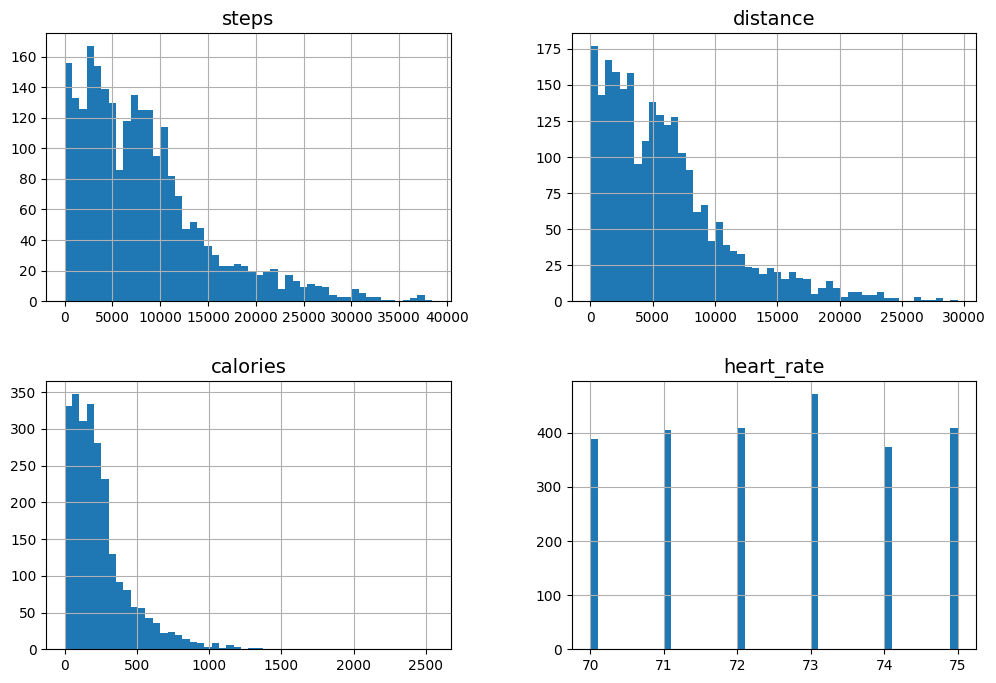

In [33]:
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

data.hist(bins=50, figsize=(12, 8))  # extra code
plt.show()

In [36]:
import numpy as np
import pandas as pd

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


In [37]:
train_set, test_set = shuffle_and_split_data(data, 0.2)
len(train_set)

80

In [38]:
len(test_set)

20

In [39]:
np.random.seed(42)

In [40]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [48]:
data['id'] = data['steps'] * 1000 + data['distance']
train_data, test_data = split_data_with_id_hash(data, 0.2, "id")

In [49]:
print("Train Data:\n", train_data.head())
print("\nTest Data:\n", test_data.head())

Train Data:
    steps  distance  calories  heart_rate        id
0  12026      3217       729         117  12029217
1  19312      6729       421          61  19318729
2   9915      9648       306         110   9924648
3   8336      8927       116          68   8344927
4   4267      7369       494         108   4274369

Test Data:
     steps  distance  calories  heart_rate        id
6   15725      3445       620         108  15728445
11  11074       506       123          84  11074506
16  12039      5951       387          60  12044951
17  16724      7252       764          68  16731252
19   7841      7296       193          89   7848296


In [53]:
#shows how to compute the 10.7% proba of getting a bad sample
from scipy.stats import binom

sample_size = 1000
ratio_high_heart_rate = 0.40

proba_too_small = binom(sample_size, ratio_high_heart_rate).cdf(350 - 1)
proba_too_large = 1 - binom(sample_size, ratio_high_heart_rate).cdf(450)

print(proba_too_small + proba_too_large)

0.0011060234451005272


In [54]:
#shows another way to estimate the probability of bad sample

np.random.seed(42)

samples = (np.random.rand(100_000, sample_size) < ratio_high_heart_rate).sum(axis=1)
((samples < 485) | (samples > 535)).mean()

np.float64(1.0)

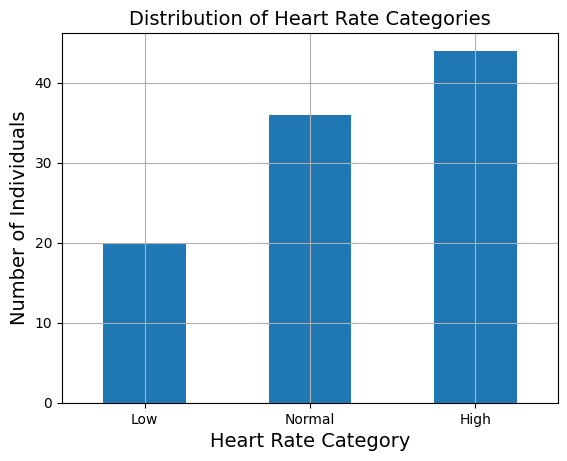

In [58]:
import matplotlib.pyplot as plt

#Create a heart rate category if it doesn't exist
data['heart_rate_cat'] = pd.cut(data['heart_rate'], bins=[0, 70, 90, 200], labels=["Low", "Normal", "High"])

data['heart_rate_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Heart Rate Category")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Heart Rate Categories")
plt.show()


In [61]:
from sklearn.model_selection import StratifiedShuffleSplit

#Ensure 'heart_rate_cat' column exists
data['heart_rate_cat'] = pd.cut(data['heart_rate'], bins=[0, 70, 90, 200], labels=["Low", "Normal", "High"])

# Initialize StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []

#Perform stratified sampling based on 'heart_rate_cat'
for train_index, test_index in splitter.split(data, data["heart_rate_cat"]):
    strat_train_set_n = data.iloc[train_index]
    strat_test_set_n = data.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [62]:
strat_train_set, strat_test_set = strat_splits[0]

In [64]:
strat_train_set, strat_test_set = train_test_split(
    data, test_size=0.2, stratify=data["heart_rate_cat"], random_state=42)

In [65]:
strat_test_set["heart_rate_cat"].value_counts() / len(strat_test_set)

heart_rate_cat
High      0.45
Normal    0.35
Low       0.20
Name: count, dtype: float64

In [66]:
def heart_rate_cat_proportions(data):
    return data["heart_rate_cat"].value_counts() / len(data)

# Assume 'heart_rate_cat' column is created in the data
train_set, test_set = train_test_split(data, test_size=0.2, stratify=data["heart_rate_cat"], random_state=42)

compare_props = pd.DataFrame({
    "Overall %": heart_rate_cat_proportions(data),
    "Stratified %": heart_rate_cat_proportions(strat_test_set),
    "Random %": heart_rate_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Heart Rate Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] / compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] / compare_props["Overall %"] - 1)

(compare_props * 100).round(2)


,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Heart Rate Category,,,,,
Low,20.0,20.0,20.0,0.00,0.00
Normal,36.0,35.0,35.0,-2.78,-2.78
High,44.0,45.0,45.0,2.27,2.27
